# Imports & Setup

In [1]:
!pip install transformers
!pip install torch
!pip install numpy
!pip install nltk
!pip install openpyxl
!pip install pymupdf
!pip install python-docx
!pip install python-pptx
!pip install pytesseract
!pip install umap-learn
!pip install hdbscan
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

#  Library Imports and Module Setup

In [2]:
# Standard Python Libraries
import os                                                 # File/folder operations
import re                                                 # Regular expressions for text cleaning
import csv                                                # CSV file handling
import shutil                                             # File operations (copy, move)
from collections import defaultdict                       # Grouping by cluster

# Parallel Processing
import multiprocessing as mp                              # Speed up processing with multiple cores

# Image & OCR
from PIL import Image, ImageFilter                        # Image preprocessing for OCR
import pytesseract                                        # OCR from image files

# Document File Handling
import fitz                                               # PDF text extraction (PyMuPDF)
import docx                                               # DOCX text extraction
import pandas as pd                                       # Excel (XLSX) data handling
from pptx import Presentation                             # PPTX text extraction

# Text Processing
import nltk                                               # Sentence tokenization
from nltk.tokenize import sent_tokenize

# Embedding Models
from transformers import AutoTokenizer, AutoModel         # Huggingface transformer models
import torch                                              # PyTorch backend
from sentence_transformers import SentenceTransformer     # Optional: for quick sentence embeddings

# Clustering & Dimensionality Reduction
import numpy as np                                        # Matrix and vector ops
import umap                                               # UMAP for dimensionality reduction
import hdbscan                                            # HDBSCAN clustering algorithm
from sklearn.decomposition import PCA                     # Optional: PCA visualization

# Visualization
import matplotlib                                         # Plotting backend
import matplotlib.pyplot as plt                           # Plotting (2D cluster visualization)

# Input Data Directory Path

In [181]:
INPUT_FOLDER = "/demo_data"

# Document Text Extraction Functions

In [182]:
def extract_text_from_pdf(filepath):
    try:
        with fitz.open(filepath) as doc:
            return " ".join(page.get_text() for page in doc)
    except Exception as e:
        print(f"Error reading PDF {filepath}: {e}")
        return ""

def extract_text_from_docx(filepath):
    try:
        doc = docx.Document(filepath)
        return " ".join(para.text for para in doc.paragraphs)
    except Exception as e:
        print(f"Error reading DOCX {filepath}: {e}")
        return ""

def extract_text_from_excel(filepath):
    try:
        dfs = pd.read_excel(filepath, sheet_name=None, dtype=str)
        content = []
        for sheet_name, df in dfs.items():
            content.append(sheet_name)
            content.extend(df.columns.astype(str).tolist())
            for row in df.itertuples(index=False):
                content.append(" ".join(str(cell) for cell in row))
        return " ".join(content)
    except Exception as e:
        print(f"Error reading Excel {filepath}: {e}")
        return ""

def extract_text_from_pptx(filepath):
    try:
        prs = Presentation(filepath)
        return " ".join(shape.text for slide in prs.slides for shape in slide.shapes if hasattr(shape, "text"))
    except Exception as e:
        print(f"Error reading PPTX {filepath}: {e}")
        return ""

def extract_text_from_txt(filepath):
    try:
        with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    except Exception as e:
        print(f"Error reading TXT {filepath}: {e}")
        return ""

def extract_text_from_image(filepath):
    try:
        img = Image.open(filepath).convert("L").filter(ImageFilter.SHARPEN)
        return pytesseract.image_to_string(img)
    except Exception as e:
        print(f"Error reading Image {filepath}: {e}")
        return ""


# Text Preprocessing

In [183]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()


# Text Extraction Based on File Format

In [184]:
def extract_text(filepath):
    ext = filepath.lower().split(".")[-1]
    if ext == "pdf":
        return extract_text_from_pdf(filepath)
    elif ext == "docx":
        return extract_text_from_docx(filepath)
    elif ext in ["xlsx", "xls"]:
        return extract_text_from_excel(filepath)
    elif ext == "pptx":
        return extract_text_from_pptx(filepath)
    elif ext in ["jpg", "jpeg", "png"]:
        return extract_text_from_image(filepath)
    elif ext == "txt":
        return extract_text_from_txt(filepath)
    else:
        return ""

# Parallel File Processing and Text Extraction

In [185]:
def process_file(filepath):
    text = extract_text(filepath)
    if text:
        cleaned = clean_text(text)
        return filepath, cleaned
    return None

if __name__ == "__main__":
    all_filepaths = []
    for root, dirs, files in os.walk(INPUT_FOLDER):
        for file in files:
            all_filepaths.append(os.path.join(root, file))

    print(f"Found {len(all_filepaths)} files to process.")

    with mp.Pool(processes=4) as pool:  # Adjust number of processes based on CPU cores
        results = pool.map(process_file, all_filepaths)

    results = [res for res in results if res is not None]
    filepaths, texts = zip(*results)

    print(f"Extracted and cleaned {len(texts)} documents.")

Found 70 files to process.
Extracted and cleaned 70 documents.


In [186]:
# filepaths

In [187]:
# texts

# NLTK Setup for Sentence Tokenization

In [188]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('punkt', download_dir='/usr/local/nltk_data')
nltk.data.path.append('/usr/local/nltk_data')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Generating Document Embeddings Using E5 Model with Chunking and Mean Pooling

## Load Model and Initialize Tokenizer

In [189]:
model_name = "intfloat/e5-large-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

## Document Embedding Pipeline Using Sentence Transformer with Chunking and Mean Pooling

### Define Max Token Limit

In [190]:
MAX_TOKENS = tokenizer.model_max_length  # Max tokens supported by the model


### Chunking & Token Count Helper

In [191]:
def get_token_length(sentences):
    return len(tokenizer(" ".join(sentences), truncation=False)["input_ids"])


### Document Chunking (based on token limit)

In [192]:
def chunk_document(text, max_tokens=MAX_TOKENS):
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        current_chunk.append(sentence)
        if get_token_length(current_chunk) > max_tokens - 10:
            current_chunk.pop()
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks


### Embedding Function (with Mean Pooling + Normalization)

In [193]:
def embed_document(text, max_tokens=MAX_TOKENS):
    chunks = chunk_document(text, max_tokens=max_tokens)
    embeddings = []

    with torch.no_grad():
        for chunk in chunks:
            chunk = f"Represent this document for clustering: {chunk}"
            inputs = tokenizer(chunk, return_tensors="pt", truncation=True, padding=True, max_length=max_tokens)
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state
            attention_mask = inputs["attention_mask"]
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            masked_embeddings = last_hidden * mask
            summed = torch.sum(masked_embeddings, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / counts
            embeddings.append(mean_pooled.squeeze(0).numpy())

    # Average chunk embeddings and normalize
    final_vec = np.mean(embeddings, axis=0)
    final_vec = final_vec / np.linalg.norm(final_vec)
    return final_vec


### Generate Embeddings for All Documents

In [194]:
document_embeddings = np.array([embed_document(text) for text in texts])

In [196]:
print(document_embeddings.shape)

(70, 1024)


In [197]:
document_embeddings

array([[-0.00098695, -0.04092295,  0.01689769, ..., -0.03963732,
         0.03385262,  0.02308849],
       [-0.00262972, -0.04942258,  0.01433025, ..., -0.03818393,
         0.02135104,  0.01634243],
       [ 0.01956118, -0.056453  , -0.03578969, ..., -0.05407922,
         0.04566353,  0.03762237],
       ...,
       [ 0.03205365, -0.05554656,  0.02689663, ..., -0.05198378,
         0.0340944 ,  0.02698332],
       [ 0.0014483 , -0.02512893,  0.00132716, ..., -0.00744278,
         0.03001007,  0.00378347],
       [-0.00257116, -0.06609721, -0.00108526, ..., -0.03041507,
         0.02516212,  0.00474428]], dtype=float32)

# Find Best Values

In [198]:
from sklearn.metrics import silhouette_score
import umap
import hdbscan
import numpy as np

# UMAP search space
n_neighbors_list = [5, 10, 15, 30]
min_dist_list = [0.0, 0.1, 0.3]
n_components_list = [10, 20]

# HDBSCAN search space
min_cluster_sizes = [3, 5, 7, 10]
min_samples_list = [1, 3, 5, 10]

# Track best combination
best_score = -1
best_params = {}
results = []

for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        for n_components in n_components_list:
            try:
                # Step 1: UMAP
                umap_reduced = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    metric='cosine',
                    random_state=42
                ).fit_transform(document_embeddings)

                for min_cluster_size in min_cluster_sizes:
                    for min_samples in min_samples_list:
                        try:
                            # Step 2: HDBSCAN
                            clusterer = hdbscan.HDBSCAN(
                                min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                metric='euclidean',
                                prediction_data=True,
                                cluster_selection_method='eom'
                            )
                            labels = clusterer.fit_predict(umap_reduced)

                            # Skip if all noise or one cluster
                            if len(set(labels)) <= 1 or np.all(labels == -1):
                                continue

                            # Step 3: Evaluate only on non-noise
                            valid_idx = labels != -1
                            score = silhouette_score(umap_reduced[valid_idx], labels[valid_idx])

                            results.append({
                                "n_neighbors": n_neighbors,
                                "min_dist": min_dist,
                                "n_components": n_components,
                                "min_cluster_size": min_cluster_size,
                                "min_samples": min_samples,
                                "silhouette": score
                            })

                            print(f"UMAP(n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}) + "
                                  f"HDBSCAN(min_cluster_size={min_cluster_size}, min_samples={min_samples}) → "
                                  f"Silhouette: {score:.4f}")

                            if score > best_score:
                                best_score = score
                                best_params = results[-1]

                        except Exception as e:
                            print(f"  ⚠️ Error in HDBSCAN: {e}")
            except Exception as e:
                print(f"❌ Error in UMAP (n_neighbors={n_neighbors}, min_dist={min_dist}, n_components={n_components}): {e}")

# Display best configuration
print("\n✅ Best Configuration:")
for k, v in best_params.items():
    print(f"{k} = {v}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/

UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.5961
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.7169
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.7716
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.6999
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.7716
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.7716
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.7716
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6999
UMAP(n_neighbors=5, min_dist=0.0, n_components=10) + HDBSCAN(m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.6233
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.7290
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.7924
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.7924
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.7924
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.7924
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.7924
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.7924
UMAP(n_neighbors=5, min_dist=0.1, n_components=10) + HDBSCAN(m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.5610
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.7543
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.7543
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.7403
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.7543
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.7543
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.7543
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.7403
UMAP(n_neighbors=5, min_dist=0.3, n_components=10) + HDBSCAN(m

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.6085
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.6581
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.6581
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.6581
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.6700
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.7018
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.6581
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6581
UMAP(n_neighbors=10, min_dist=0.0, n_components=10) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=1) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=3) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=5) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=10) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=10, min_samples=1) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=10, min_samples=3) → Silhouette: 0.7800
UMAP(n_neighbors=10, min_dist=0.0, n_components=20) 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.5004
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.5215
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.5634
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.5634
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.5215
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.6353
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.5634
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.5634
UMAP(n_neighbors=10, min_dist=0.1, n_components=20) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=10, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=5) → Silhouette: 0.5798
UMAP(n_neighbors=10, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=10) → Silhouette: 0.4993
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.4085
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.4815
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.5966
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.6486
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.4907
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.4815
UMAP(n_neighbors=10, min_dist=0.3, n_components=20) 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.4946
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.6281
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.6281
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.7384
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.6281
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.6281
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.6281
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.7384
UMAP(n_neighbors=15, min_dist=0.0, n_components=10) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.4754
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.5824
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.6187
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.7035
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=1) → Silhouette: 0.4754
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=3) → Silhouette: 0.5824
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=5) → Silhouette: 0.6187
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=10) → Silhouette: 0.7035
UMAP(n_neighbors=15, min_dist=0.0, n_components=20) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.3700
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.4230
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.6603
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.6620
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.4776
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.4230
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.6603
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6620
UMAP(n_neighbors=15, min_dist=0.1, n_components=20) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=15, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=5) → Silhouette: 0.6036
UMAP(n_neighbors=15, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=10) → Silhouette: 0.5126
UMAP(n_neighbors=15, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=1) → Silhouette: 0.3672
UMAP(n_neighbors=15, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=3) → Silhouette: 0.3672
UMAP(n_neighbors=15, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=5) → Silhouette: 0.6036
UMAP(n_neighbors=15, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=10) → Silhouette: 0.5126
UMAP(n_neighbors=15, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.3083
UMAP(n_neighbors=15, min_dist=0.3, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.4746
UMAP(n_neighbors=15, min_dist=0.3, n_components=20

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.3914
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.5202
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.5809
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.6353
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.5050
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.4195
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.6195
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6058
UMAP(n_neighbors=30, min_dist=0.0, n_components=10) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=1) → Silhouette: 0.4095
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=3) → Silhouette: 0.4588
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=5) → Silhouette: 0.5363
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.6213
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.4767
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.5138
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.5363
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6615
UMAP(n_neighbors=30, min_dist=0.0, n_components=20) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.4930
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.5853
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6364
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=1) → Silhouette: 0.5048
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=3) → Silhouette: 0.5691
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=5) → Silhouette: 0.5381
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=10) → Silhouette: 0.5932
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=1) → Silhouette: 0.4015
UMAP(n_neighbors=30, min_dist=0.1, n_components=10) +

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=3, min_samples=10) → Silhouette: 0.5902
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=1) → Silhouette: 0.4624
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=3) → Silhouette: 0.5226
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=5) → Silhouette: 0.5273
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.6215
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=1) → Silhouette: 0.4624
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=3) → Silhouette: 0.5226
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + HDBSCAN(min_cluster_size=7, min_samples=5) → Silhouette: 0.5273
UMAP(n_neighbors=30, min_dist=0.1, n_components=20) + 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=5, min_samples=10) → Silhouette: 0.5815
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=1) → Silhouette: 0.4322
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=3) → Silhouette: 0.5238
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=5) → Silhouette: 0.5098
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=7, min_samples=10) → Silhouette: 0.5815
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=1) → Silhouette: 0.5211
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=3) → Silhouette: 0.3777
UMAP(n_neighbors=30, min_dist=0.3, n_components=10) + HDBSCAN(min_cluster_size=10, min_samples=5) → Silhouette: 0.5098
UMAP(n_neighbors=30, min_dist=0.3, n_components=10)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

# UMAP Dimensionality Reduction for Clustering

In [199]:
umap_reduced = umap.UMAP(
    n_components=20,
    n_neighbors=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
).fit_transform(document_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [200]:
print(umap_reduced.shape)

(70, 20)


# Find Best Method ('eom' or 'leaf')

In [201]:
from sklearn.metrics import silhouette_score

best_method = None
best_score = -1

for method in ['eom', 'leaf']:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=10,
        metric='euclidean',
        cluster_selection_method=method
    )
    labels = clusterer.fit_predict(umap_reduced)
    if len(set(labels)) > 1 and len(set(labels)) != 1 and np.sum(labels != -1) > 0:
        score = silhouette_score(umap_reduced[labels != -1], labels[labels != -1])
        print(f"{method}: silhouette = {score:.3f}")
        if score > best_score:
            best_score = score
            best_method = method

print(f"Best method: {best_method} with silhouette score: {best_score:.3f}")


eom: silhouette = 0.805
leaf: silhouette = 0.798
Best method: eom with silhouette score: 0.805


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 # Clustering with HDBSCAN

In [202]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    min_samples=5,
    metric='euclidean',
    prediction_data=True,
    cluster_selection_method='eom'
)
labels = clusterer.fit_predict(umap_reduced)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# UMAP 2D Visualization of HDBSCAN Clusters

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


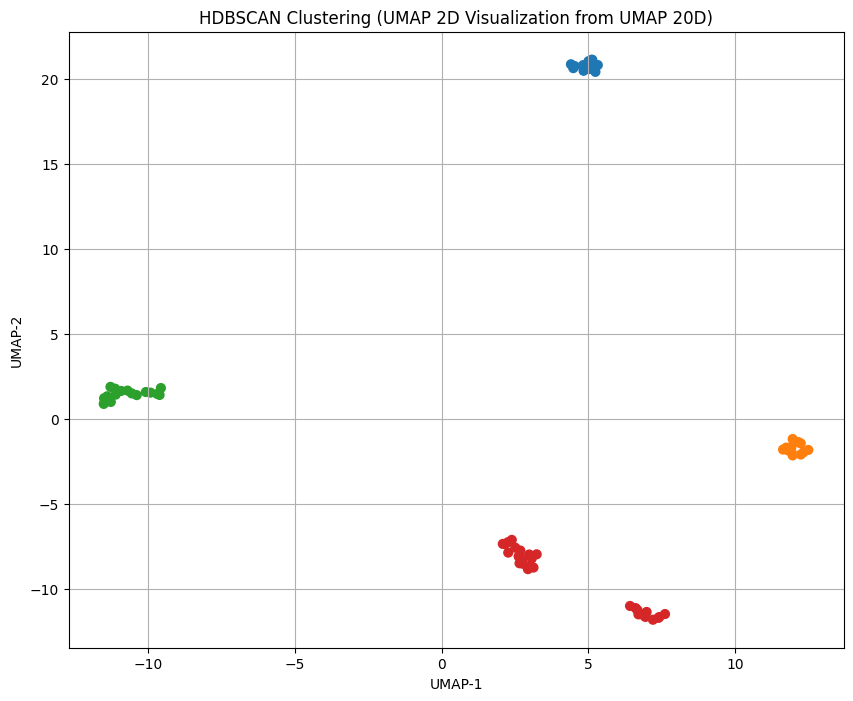

In [203]:
visual_embeddings = umap.UMAP(
    n_components=2,
    metric='euclidean',
    random_state=42
).fit_transform(umap_reduced)

plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
palette = matplotlib.colormaps.get_cmap('tab10')
colors = [palette(label % 10) if label != -1 else 'black' for label in labels]

plt.scatter(visual_embeddings[:, 0], visual_embeddings[:, 1], c=colors, s=40)
plt.title("HDBSCAN Clustering (UMAP 2D Visualization from UMAP 20D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


# Save Output

In [204]:
FILE_OUTPUT_TXT = "/prj_output_16/grouped_files_by_cluster_16.txt"
FILE_OUTPUT_FOLDER = "/prj_output_16/DRDO_Clustered_Files"

### Group And Save Cluster List

In [205]:
clusters = defaultdict(list)
for filepath, label in zip(filepaths, labels):
    clusters[label].append(filepath)

with open(FILE_OUTPUT_TXT, "w", encoding="utf-8") as f:
    for label, files in sorted(clusters.items()):
        f.write(f"Cluster {label}:")
        f.write("\n")
        for file in files:
            f.write(f"  {file}\n")
        f.write("\n")

### Copy Files into Cluster Folder Including Noise

In [206]:
all_labels = sorted(set(labels))  # includes -1 if any

for label, files in sorted(clusters.items()):
    cluster_folder = os.path.join(FILE_OUTPUT_FOLDER, f"Cluster_{label}")
    os.makedirs(cluster_folder, exist_ok=True)
    for file in files:
        try:
            shutil.copy(file, cluster_folder)
        except Exception as e:
            print(f"Error copying file {file} to {cluster_folder}: {e}")

print(f"All clustered files (including noise as Cluster -1) saved into '{FILE_OUTPUT_FOLDER}'.")


All clustered files (including noise as Cluster -1) saved into '/prj_output_16/DRDO_Clustered_Files'.


# Create and Download Zip of Output Folder

In [207]:
import shutil

shutil.make_archive('/content/prj_output_16', 'zip', '/prj_output_16')


'/content/prj_output_16.zip'

In [208]:
from google.colab import files

files.download('/content/prj_output_16.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>